In [2]:
# ヨンテさん
from transformers.models.bert_japanese.tokenization_bert_japanese import BertJapaneseTokenizer
from wtfml.data_loaders.nlp.utils import clean_sentence
import torch
from glob import glob
import os
from wtfml.engine.nlp.model import BERTBaseClassifier
import pandas as pd
import numpy as np

# オガワ
from wtfml.cross_validation.fold_generator import FoldGenerator
from wtfml.data_loaders.nlp.classification import BERTSimpleDataset # datasetを変更
from wtfml.data_loaders.pl_data_module.data_module import plDataModule
from wtfml.engine.nlp.model import BERTBaseClassifier
from wtfml.engine.pl_engine.BERT_classification import BERTClassificationPlEngine


device = 'cuda:0'
tokenizer = BertJapaneseTokenizer.from_pretrained(
                    "cl-tohoku/bert-base-japanese-whole-word-masking"
                )

result_list = []
result_for_series = []
for fold in range(5):
    base_folder = "/home/jupyter/ogawa_prediction/model/2021-08-13/{}/".format(fold)
    model_path = glob(os.path.join(base_folder, "epoch*"))[0]
    classification_model = BERTBaseClassifier(num_classes = 4)
    pl_engine = BERTClassificationPlEngine(model = classification_model)
    pl_engine.load_from_checkpoint(model_path, model = classification_model)

    validation_df = pd.read_csv(os.path.join(base_folder,"valid_table.csv"))

    # display(validation_df.head())
    cnt = 0
    for profile_text_row, target in zip(validation_df["description"], validation_df["target"]):
        profile_text = clean_sentence(profile_text_row)

        inputs = tokenizer.encode_plus(
                profile_text,
                None,
                add_special_tokens=True,
                # max_length=self.max_len,
                # padding="max_length",
                truncation=True,
                # return_tensors="pt"
            )

        ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(device).unsqueeze(0)
        mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(device).unsqueeze(0)
        token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).to(device).unsqueeze(0)
        
        pl_engine.to(device).eval()
        with torch.no_grad():
            prediction =  pl_engine(ids, mask, token_type_ids)
        prediction = torch.softmax(prediction, dim = 1).cpu().numpy()
        result_list.append([prediction, np.argmax(prediction) , validation_df["target"].tolist()[cnt]])
        result_for_series.append(prediction[0])
        cnt += 1


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertM

In [6]:
# create dataframe for confusion_matrix
res_df = pd.DataFrame(result_list)
res_df = pd.DataFrame(res_df).iloc[:,0]
total_df = pd.DataFrame([row[0] for row in res_df])
total_df["target"] = pd.DataFrame(result_list).iloc[:,2]
total_df

,0,1,2,3,target
0,0.899096,0.081366,0.011146,0.008392,0
1,0.460776,0.331773,0.056786,0.150665,0
2,0.052037,0.065269,0.501430,0.381264,3
3,0.832494,0.152619,0.007105,0.007781,0
4,0.056939,0.161098,0.132210,0.649753,3
...,...,...,...,...,...
4646,0.003952,0.007311,0.973174,0.015563,2
4647,0.004876,0.009586,0.971467,0.014071,2
4648,0.011545,0.017065,0.958108,0.013283,2
4649,0.004309,0.007876,0.973773,0.014042,2


## 4クラスで混合行列
- 既婚（子供あり）： 0
- 既婚（子供不明）: 1
- 未婚（恋人あり）: 2
- 未婚（恋人不明）: 3

[0, 1, 2, 3]
[0.0, 1.0, 2.0, 3.0]


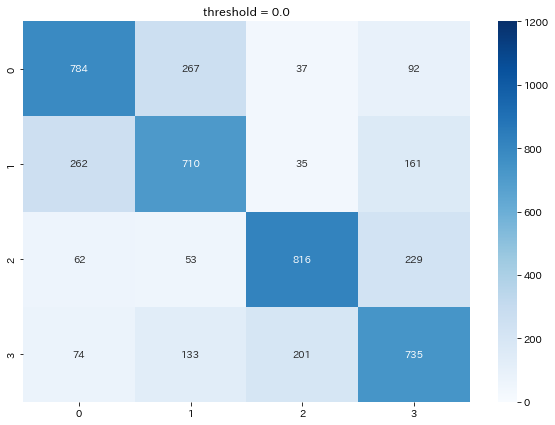

     0    1    2    3
0  784  267   37   92
1  262  710   35  161
2   62   53  816  229
3   74  133  201  735
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      1180
         1.0       0.61      0.61      0.61      1168
         2.0       0.75      0.70      0.73      1160
         3.0       0.60      0.64      0.62      1143

    accuracy                           0.65      4651
   macro avg       0.66      0.65      0.66      4651
weighted avg       0.66      0.65      0.66      4651

1.0


In [15]:
# 4クラスで混合行列
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns

threshold = .0


labels_for_plot = [0, 1, 2, 3]
print(labels_for_plot)
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_for_plot, columns=labels_for_plot)
    print(labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True,vmin=0,vmax = 1200, cmap="Blues", fmt="d")
    plt.title("threshold = {}".format(threshold))
    plt.show()
    return df_cmx

def softmax(x):
    u = np.sum(np.exp(x))
    return np.exp(x)/u

prediction = []
target = []

for i,result_df in total_df.iterrows():
    result = result_df[[0,1,2,3]].values
    _target = result_df["target"]

    if np.max(result) >threshold:
        prediction.append(np.argmax(result))
        target.append(_target)

confudion_metrix = print_cmx(target, prediction)
print(confudion_metrix)
acc = classification_report(target, prediction)
print(acc)

print(len(target)/total_df.shape[0])

## 2クラスで混合行列
- 既婚： 0
- 未婚: 1

In [16]:
# 2値分類での混合行列
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns

threshold = .0

labels_for_plot = [0, 1]
print(labels_for_plot)
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_for_plot, columns=labels_for_plot)
    print(labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True,vmin=0,vmax = 2400, cmap="Blues", fmt="d")
    plt.title("threshold = {}".format(threshold))
    plt.show()
    return df_cmx

def softmax(x):
    u = np.sum(np.exp(x))
    return np.exp(x)/u

prediction = []
target = []

for i,result_df in total_df.iterrows():
    result = result_df[[0,1,2,3]].values
    _target = result_df["target"]

    if np.max(result) >threshold:
      if (np.argmax(result) == 0 or np.argmax(result) == 1) and (_target == 0 or _target == 1):
        prediction.append(0)
        target.append(0)
      elif (np.argmax(result) == 0 or np.argmax(result) == 1) and (_target == 2 or _target == 3):
        prediction.append(0)
        target.append(1)
      elif (np.argmax(result) == 2 or np.argmax(result) == 3) and (_target == 0 or _target == 1):
        prediction.append(1)
        target.append(0)
      elif (np.argmax(result) == 2 or np.argmax(result) == 3) and (_target == 2 or _target == 3):
        prediction.append(1)
        target.append(1)


[0, 1]


[0, 1]


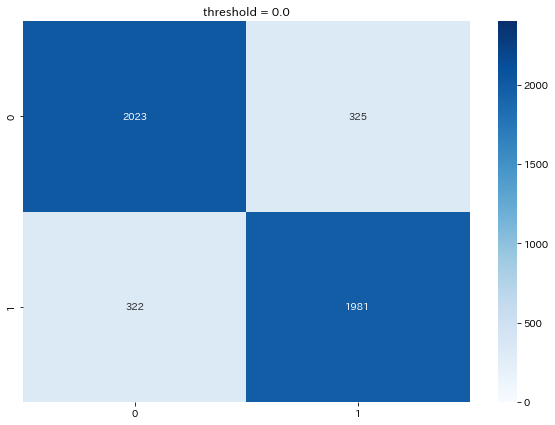

      0     1
0  2023   325
1   322  1981
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2348
           1       0.86      0.86      0.86      2303

    accuracy                           0.86      4651
   macro avg       0.86      0.86      0.86      4651
weighted avg       0.86      0.86      0.86      4651

1.0


In [17]:
confudion_metrix = print_cmx(target, prediction)
print(confudion_metrix)
acc = classification_report(target, prediction)
print(acc)

print(len(target)/total_df.shape[0])

In [14]:
%load_ext tensorboard
%tensorboard --logdir /home/jupyter/ogawa_prediction/model/2021-08-13/logs/default

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.